# Body Pose Model

จากโมเดลที่พัฒนาโดย Mediapipe ทำให้เราสามารถแสดงโครงลำตัวได้ โดยอาศัยการเรียนรู้ภาพต้นแบบสามมิติ นำมาหาค่าพิกัดที่สำคัญ เพื่อใช้แสดงผลเป็นรูปทรงเรขาคณิตจำนวน 17 พิกัด ดังรูป <br><br>

![body_landmarks.png](https://raw.github.com/hengkp/mediapipe_examples/main/landmarks/body_landmarks.png)<br><br>

ในการวัดมุมของใบหน้าจะถูกแบ่งเป็น 4 ท่าทาง ได้แก่ ยกแขนขวา, ยกแขนซ้าย, ยกสองแขน, หุบแขน

1. **ยก / หุบ แขนขวา** ทำการวัดจุดข้อมือขวากับจุดหัวไหล่ด้านขวา (ตำแหน่งที่ 6 & 8 กับ 10) โดยวัดในระนาบทางสูงอย่างเดียว ในกรณีที่ความสูงของข้อมือ *มากกว่า* หัวไหล่ จะถูกนับว่ายกมือขวา

2. **ยก / หุบ แขนซ้าย** ทำการวัดจุดข้อมือซ้ายกับจุดหัวไหล่ด้านซ้าย (ตำแหน่งที่ 5 & 7 กับ 9) โดยวัดในระนาบทางสูงอย่างเดียว ในกรณีที่ความสูงของข้อมือ *มากกว่า* หัวไหล่ จะถูกนับว่ายกมือซ้าย

<br>

**ตัวอย่างโค้ด**ด้านล่าง จะเป็นการเขียนโปรแกรมเพื่อใช้งานตัวโมเดลจาก Mediapipe ในการทำนายท่าทาง และแสดงผลเป็นรูปภาพพร้อมจุดพิกัดและเส้นเชื่อมแสดงรูปทรงเรขาคณิตของลำตัว โดยประกอบด้วย 7 ขั้นตอนดังต่อไปนี้
<br><br>
![body_workflow.jpg](https://raw.github.com/hengkp/mediapipe_examples/main/workflows/body_workflow.jpg)


In [3]:
#@title **ขั้นตอนที่ 1** การนำเข้าโมเดลจาก Mediapipe

import requests
import os
import tensorflow as tf

# ที่อยู่ของโมเดลที่ต้องการนำเข้า
model_url = "https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite"

# ดาวน์โหลดโมเดลมาเก็บไว้ที่เครื่อง
if not os.path.exists("body_model.tflite"):
    response = requests.get(model_url)
    open("body_model.tflite", "wb").write(response.content)

# นำเข้าโมเดล
model = tf.lite.Interpreter(model_path="body_model.tflite")
model.allocate_tensors()

# เก็บข้อมูลข้อกำหนดของโมเดลสำหรับการเตรียมรูปภาพ
input_details = model.get_input_details()
output_details = model.get_output_details()

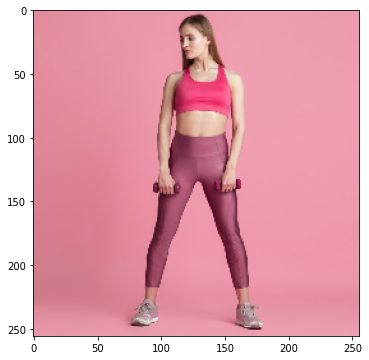

In [15]:
#@title **ขั้นตอนที่ 2-3** นำเข้าและปรับขนาดของภาพให้สอดคล้องกับข้อกำหนดของโมเดล
from matplotlib import pyplot as plt
import numpy as np
import cv2
from skimage import io

# ใส่ที่อยู่ของภาพที่ต้องการนำเข้า
image_path = "https://raw.githubusercontent.com/hengkp/mediapipe_examples/main/datasets/body/body1.jpg"

# ขั้นตอนที่ 2 นำเข้าภาพ
img = io.imread(image_path)

# ขั้นตอนที่ 3 ปรับขนาดภาพให้สอดคล้องกับความต้องการของโมเดล
img = cv2.resize(img, (input_details[0]['shape'][1], input_details[0]['shape'][2])) # resize to match inputs of model
img = img.astype(np.uint8)

# แสดงตัวอย่างภาพ
fig = plt.figure(figsize=(6, 6)) # define size of figure
plt.imshow(img) # display image in the figure
plt.show()

In [16]:
#@title **ขั้นตอนที่ 4-5** ประมวลผลรูปผ่านโมเดลเพื่อทำนายจุดพิกัดสำคัญ

# เขียนฟังก์ชั่นสำหรับดึงข้อมูลพิกัดที่สำคัญ
def keypoints_conversion(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    keypoints_xy as the coordinates of all keypoints of all detected entities
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))
  return keypoints_xy

# ขั้นตอนที่ 4 ประมวลผลภาพ
model.set_tensor(input_details[0]['index'], [img])
model.invoke()

# ขั้นตอนที่ 5 ดึงข้อมูลพิกัดที่สำคัญที่ได้จากผลการประมวล
keypoints = model.get_tensor(output_details[0]['index'])
keypoints = np.squeeze(keypoints_conversion(keypoints,
                     input_details[0]['shape'][1],
                     input_details[0]['shape'][2]))

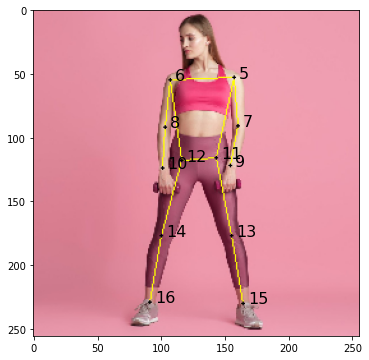

In [18]:
#@title **ขั้นตอนที่ 6** แสดงผลรูปการทำนายมือ

from matplotlib import pyplot as plt

# เตรียมรูปภาพเพื่อแสดงผล
if np.max(img) <= 1:
    img = (img * 255).astype(np.uint8) # convert image back to [0..255] format
fig, ax = plt.subplots(figsize=(6, 6)) # define size of figure

# วาดเส้นเชื่อมระหว่างพิกัด
keypoints_pairs = [(5,6),(6,12),(12,11),(11,5),(5,7),(7,9),(6,8),(8,10),(12,14),(14,16),(11,13),(13,15)]
for pair in keypoints_pairs: # loop each key pair to draw line
    x1, y1 = int(keypoints[pair[0],0]), int(keypoints[pair[0],1])
    x2, y2 = int(keypoints[pair[1],0]), int(keypoints[pair[1],1])
    cv2.line(img, (x1, y1), (x2, y2), (255, 255, 0), 1) # draw a line

# วาดจุดพิกัดลงในภาพ
for i in [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]:
    kp = (int(keypoints[i,0]), int(keypoints[i,1]))
    cv2.circle(img, kp, 1, (0, 0, 0), -1)

# ใส่หมายเลขบอกพิกัด
for i in [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]:
    kp = (int(keypoints[i,0]), int(keypoints[i,1]))
    ax.annotate(i, kp, fontsize=16, xytext=(5,0), textcoords='offset points') # write text of keypoint ID

# แสดงผลรูปภาพพร้อมพิกัด
plt.imshow(img)
plt.show()

In [19]:
#@title **ขั้นตอนที่ 7** แสดงผลแขนที่ยกขึ้น

# กำหนดตำแหน่งของข้อมือเทียบกับข้อศอกในแต่ละข้าง
left_side = "raise left" if ((keypoints[9,1] - keypoints[5,1]) < 0) or ((keypoints[9,1] - keypoints[7,1]) < 0) else "drop"
right_side = "raise right" if ((keypoints[10,1] - keypoints[6,1]) < 0) or ((keypoints[10,1] - keypoints[8,1]) < 0) else "drop"

# สรุปผลแขนที่ยกขึ้น โดย
# ถ้าตำแหน่งข้อมืออยู่สูงกว่าข้อศอกจะถูกนับว่ายกมือขึ้น
if (left_side == "raise") and (right_side == "raise"):
  text = "raise both arm"
elif (left_side == "drop") and (right_side == "drop"):
  text = "drop both arm"
elif (left_side == "drop"):
  text = right_side
else:
  text = left_side

# แสดงผลแขนที่ยกขึ้น
print("Direction of Arm:", text)

Direction of Arm: drop both arm
